# Real world example: Yeast Biolector Fermentation
I this notebook, we will show how to apply the Pseudobatch transformation to data collected of a fed-batch experiment. We will showcase how to transform data from multiple cultures/replicates in one go and how to estimate the growth rate of each culture.

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm


from pseudobatch import pseudobatch_transform_pandas
from pseudobatch.datasets import load_real_world_yeast_fedbatch 


This data is from a cultivation experiment done in a Biolector (actually a Robolector) operating in fed-batch mode. Four different __S. cerevisiae__ strains were cultivated in 8 replicates, there only difference is when the individual culture was sampled and how many times samples were drawn. Thus the dataset contains a total of 32 growth curves. In this tutorial we will show how to use pseudobatch transformation to transform all 32 growth curves and how to estimate the growth rate for each replicate.

The Biolector is capable of collect online biomass measurements through the light scatter sensor. Thus this dataset contains a biomass measurement for each approximately fifth minute.

First, we will load the dataset which is a part of the `pseudobatch.datasets`, thus is is easily loaded.

In [4]:
fedbatch_df = load_real_world_yeast_fedbatch()
fedbatch_df.head()

,Strain,Biolector well,Biolector column,Biolector row,Cycle,Time,Feeding time,Volume,Accum. feed [uL],Biomass concentration [light scatter],DO%,Sample volume
0,Yeast_strain_1,C01,1,C,145.0,14.5028,0.2,800.32,0.32,2.89,147.440002,0.0
1,Yeast_strain_1,C01,1,C,146.0,14.6028,0.3,800.48,0.48,3.00,147.300003,0.0
2,Yeast_strain_1,C01,1,C,147.0,14.7028,0.4,800.64,0.64,2.83,147.830002,0.0
3,Yeast_strain_1,C01,1,C,148.0,14.8028,0.5,800.80,0.80,2.95,147.779999,0.0
4,Yeast_strain_1,C01,1,C,150.0,15.0028,0.7,800.96,0.96,2.84,148.360001,0.0


This dataset is preprocessed into a format that is very similar to the format of the simulated datasets used in the previous tutorials. This format follows the "Tidy"-format also called "long-format". Each row represent measurements of one culture at one time point. For example row 0 above hold the biomass, Volume, and Accumulated feed measurements etc of Biolector well C01 at feeding time 0.2 hours (time relative to feed initiation).

To get started lets have look at the growth curves (light scatter measurements).

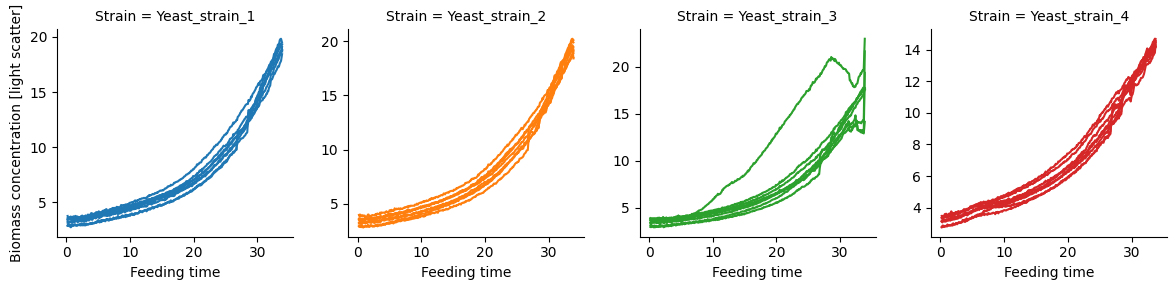

In [5]:
# plotting
g = sns.FacetGrid(fedbatch_df, col="Strain", hue="Strain", sharey=False)
g.map_dataframe(sns.lineplot, data=fedbatch_df, x='Feeding time', y='Biomass concentration [light scatter]', units="Biolector well", estimator=None)

In [6]:
biomass_concentration_in_feed = 0 # There is no yeast cells in the feed medium

# Apply pseudobatch transformation and save the transformed biomass concentration in a new column
fedbatch_df[["Biomass pseudo concentration"]] = (fedbatch_df
    .groupby("Biolector well", group_keys=False)
    .apply(pseudobatch_transform_pandas,  
        measured_concentration_colnames=["Biomass concentration [light scatter]"], # we wish to transform the biomass concentration measurements
        reactor_volume_colname='Volume',
        accumulated_feed_colname='Accum. feed [uL]',
        concentration_in_feed=[biomass_concentration_in_feed],
        sample_volume_colname='Sample volume',
    )
)

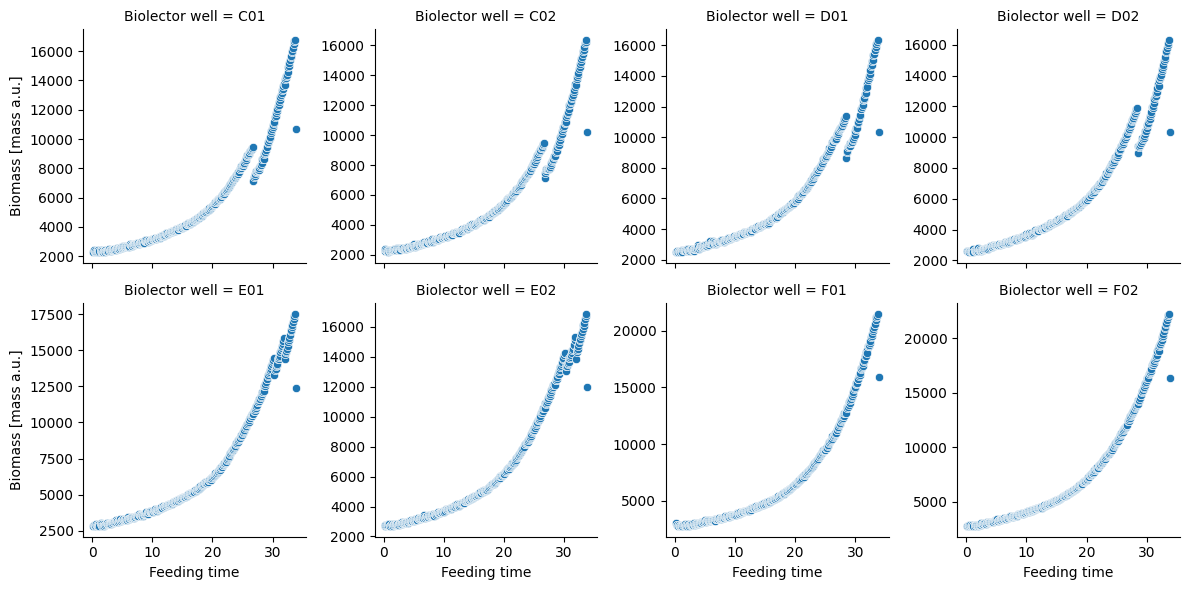

In [7]:
fedbatch_df["Volume after sampling"] = fedbatch_df["Volume"] - fedbatch_df["Sample volume"]
fedbatch_df["Biomass [mass a.u.]"] = fedbatch_df["Biomass concentration [light scatter]"] * fedbatch_df["Volume after sampling"]

# plotting
plot_df = fedbatch_df.query(
    "Strain == 'Yeast_strain_1'"
)
g = sns.FacetGrid(plot_df, col="Biolector well", col_wrap=4, hue="Strain", sharey=False)
g.map_dataframe(sns.scatterplot, x='Feeding time', y='Biomass [mass a.u.]')


In [55]:
import gaussianprocessderivatives as gp
paper_df = fedbatch_df.query("`Biolector well` == 'E01' & `Feeding time` > 25").copy()
x = paper_df['Feeding time'].to_numpy()
y = paper_df['Biomass pseudo concentration'].to_numpy()
y_raw = paper_df["Biomass [mass a.u.]"].to_numpy()


In [56]:
relative_error = 0.05
g= gp.maternGP({0: (-4, 4), 1: (-4, 4), 2: (-4, -2)}, x, y, merrors=(y*relative_error)**2)
g.findhyperparameters()
g.predict(x, derivs=1, addnoise=True)

In [57]:
g_raw = gp.maternGP({0: (-4, 4), 1: (-4, 4), 2: (-4, -2)}, x, y_raw, merrors=(y_raw*relative_error)**2)
g_raw.findhyperparameters()
g_raw.predict(x, derivs=1, addnoise=True)

In [51]:
def calc_growth_rate_from_gp(gaussian_process):
    # Calculate specific growth rate
    growth_rate = gaussian_process.df / gaussian_process.f

    # Calculate standard deviations from variances
    fstd = np.sqrt(gaussian_process.fvar) 
    dfstd = np.sqrt(gaussian_process.dfvar) 

    # Probagating the uncertainty to the specific growth rate
    growth_rate_std = abs(growth_rate) * np.sqrt((fstd/gaussian_process.f)**2 + (dfstd/gaussian_process.df)**2)
    growth_rate_var = growth_rate_std**2

    return growth_rate, growth_rate_var

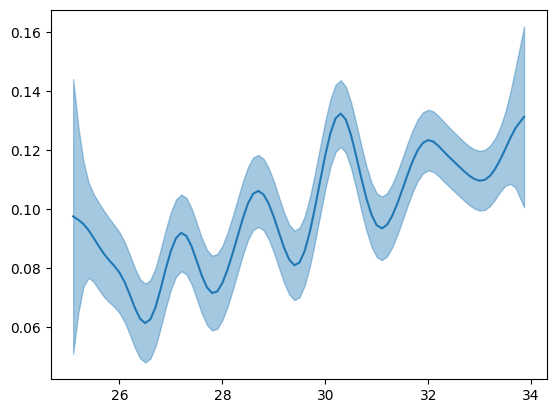

In [52]:
def plot_growth_rate_gp(gaussian_process, n_std, color='C0', uncertainty_transparency=0.4, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    growth_rate, growth_rate_var = calc_growth_rate_from_gp(gaussian_process)
    
    growth_rate_std = np.sqrt(growth_rate_var)

    ax.fill_between(
        x = gaussian_process.x,
        y1 = growth_rate - n_std*growth_rate_std,
        y2 = growth_rate + n_std*growth_rate_std,
        color=color,
        alpha=uncertainty_transparency
    )
    ax.plot(gaussian_process.x, growth_rate, color=color)

plot_growth_rate_gp(
    g,
    2
)

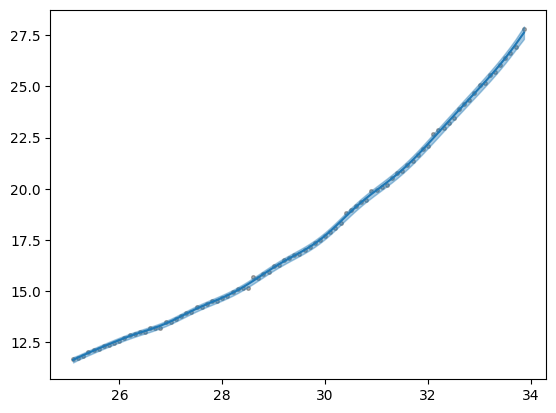

In [53]:
def plot_biomass_gp(gaussian_process, n_std, color='C0', uncertainty_transparency=0.4, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Calculate the standard deviations as each data point
    fstd = np.sqrt(gaussian_process.fvar)

    ax.scatter(gaussian_process.x, gaussian_process.y, color = "black", alpha=0.3, s=7)
    ax.fill_between(
        x = gaussian_process.x,
        y1 = gaussian_process.f - n_std*fstd,
        y2 = gaussian_process.f + n_std*fstd,
        color=color,
        alpha = uncertainty_transparency
    )
    ax.plot(
        gaussian_process.x, 
        gaussian_process.f,
        color=color
    )
plot_biomass_gp(
    g, 2
)

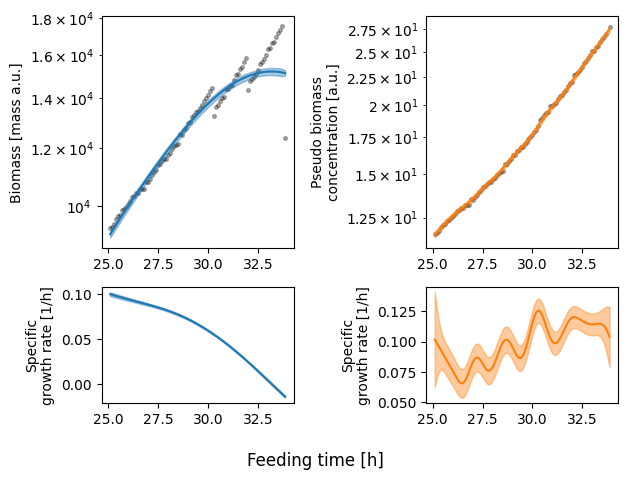

In [69]:
# combined plots 

fig, ax_tmp = plt.subplots(nrows=2, ncols=2, gridspec_kw={'height_ratios': [2, 1]})
ax = ax_tmp.flatten()

plot_biomass_gp(
    g_raw, 2, color='C0', ax=ax[0]
)
plot_biomass_gp(
    g, 2, color='C1', ax=ax[1]
)

plot_growth_rate_gp(
    g, 2, color='C1', ax=ax[3]
)

plot_growth_rate_gp(
    g_raw, 2, color='C0', ax=ax[2]
)

ax[0].semilogy()
ax[1].semilogy()
ax[0].set_ylabel("Biomass [mass a.u.]")
ax[1].set_ylabel("Pseudo biomass\nconcentration [a.u.]")
ax[2].set_ylabel("Specific\ngrowth rate [1/h]")
ax[3].set_ylabel("Specific\ngrowth rate [1/h]")
fig.supxlabel("Feeding time [h]")
fig.tight_layout()
fig.savefig("../figures/realworld_gaussian_process.jpg", dpi=300)

## Calculate growth rates using finite differences methods

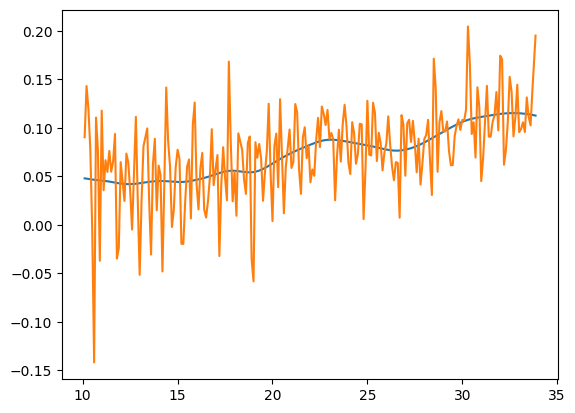

In [51]:
first_order_diff = np.gradient(paper_df['Biomass pseudo concentration'].to_numpy(), paper_df["Feeding time"].to_numpy())
growth_rate_finite_diff = first_order_diff / paper_df['Biomass pseudo concentration']
plt.plot(paper_df['Feeding time'], growth_rate)
plt.plot(paper_df['Feeding time'], growth_rate_finite_diff)

In [52]:
# Format data for QurvE
# Required columns:  ‘Time’, ‘Description’, and ‘Values’. Optional 'Replicates'
qurve_cols = ["Time", "Description", "Values", "Replicate"]
qurve_df = (
    fedbatch_df
    .drop(columns=['Time'])
    .rename(
        columns={
            "Strain": "Description",
            "Feeding time" : "Time", 
        }
    )
)

# Create replicate column
qurve_df["Replicate"] = 0
for _, strain_df in qurve_df.groupby("Description"):
    i = 1
    for _, well_df in strain_df.groupby("Biolector well"):
        qurve_df.loc[well_df.index, "Replicate"] = i
        i += 1


(qurve_df
    .rename(columns={"Biomass pseudo concentration": "Values"})
    [qurve_cols]
    .to_csv("qurve_pseudobatch_data.csv", index=False)
)
(qurve_df
    .rename(columns={"Biomass [mass a.u.]": "Values"})
    [qurve_cols]
    .to_csv("qurve_raw_biomass_data.csv", index=False)
)

In [53]:
well_df

,Description,Biolector well,Biolector column,Biolector row,Cycle,Time,Volume,Accum. feed [uL],Biomass concentration [light scatter],DO%,Sample volume,Biomass pseudo concentration,Volume after sampling,Biomass [mass a.u.],Replicate
10378,Yeast_strain_4,F08,8,F,185.0,0.200001,800.320,0.320,3.38,147.119995,0.0,3.380000,800.320,2705.081692,0
10379,Yeast_strain_4,F08,8,F,186.0,0.300001,800.480,0.480,3.42,147.000000,0.0,3.420684,800.480,2737.641661,0
10380,Yeast_strain_4,F08,8,F,187.0,0.400002,800.640,0.640,3.45,146.729996,0.0,3.451379,800.640,2762.208038,0
10381,Yeast_strain_4,F08,8,F,188.0,0.500000,800.800,0.800,3.44,146.839996,0.0,3.442063,800.800,2754.752046,0
10382,Yeast_strain_4,F08,8,F,190.0,0.700001,800.960,0.960,3.47,146.649994,0.0,3.472775,800.960,2779.331223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10707,Yeast_strain_4,F08,8,F,516.0,33.362999,1128.640,328.640,14.09,39.099998,0.0,19.870224,1128.640,15902.537772,0
10708,Yeast_strain_4,F08,8,F,517.0,33.463001,1132.160,332.160,14.12,37.380001,0.0,19.974634,1132.160,15986.099070,0
10709,Yeast_strain_4,F08,8,F,518.0,33.563000,1135.521,335.520,14.19,36.349998,0.0,20.133250,1135.521,16113.042514,0
10710,Yeast_strain_4,F08,8,F,519.0,33.663002,1139.041,339.041,14.24,33.500000,0.0,20.266823,1139.041,16219.943579,0


We don't see the discontinuities in these plots because the light scatter measurements are proportional to the concentration of biomass [1]. However, we cannot calculate the correct growth rate from the concentrations because the volume of the bioreactors (Biolector wells) is not constant. Thus, the changes in the biomass concentration is function of both growth and volume change. Luckily the pseudo batch transformation can alleviate this issue. 

To transform the data correctly, we have to apply the pseudobatch transformation to each culture (Biolector well). This can be done by using the `pseudobatch_transform_pandas()` with a groupby-apply approach.

In the following code the the `.groupby()` method creates a separate dataframe for culture/Biolector well. Then the `.apply()` method supplies these dataframes one by one first argument in pseudobatch_transform_pandas function and collects the output from all of transformation in a series. The remaining arguments to the `pseudobatch_transform_pandas()` function are the same for each execution, notice that these arguments **HAVE TO** be given as **KEYWORD ARGUMENTS**, i.e. `argument_name=value`.

Notice that the we use the `group_keys=False` argument in the groupby mehtod. This maintains the original index (order of the data), thus allowing us to write the pseudo batch transformed data directly back into the original dataframe.


Now that we have transformed the data we fit a log-linear model to each of the growth curve. Similar to previous tutorials we define a small helper function to fit the model.

In [54]:
def fit_ols_model(formula_like: str, data: pd.DataFrame) -> sm.regression.linear_model.RegressionResultsWrapper:
    y, X = dmatrices(formula_like, data)
    model = sm.OLS(endog=y, exog=X)
    res = model.fit()
    return res

We can now iterate through the data from Biolector well and estimate the growth rate.

In [55]:
growth_rate_models = {}
for grp, dat in fedbatch_df.groupby(['Strain', 'Biolector well']):
    growth_rate_models[grp] = fit_ols_model('np.log(Q("Biomass pseudo concentration")) ~ Q("Feeding time")', dat)

# collect the growth rates in a dataframe
growth_rates_df = pd.DataFrame(
    [
        [strain, well, mod.params[1]] for (strain, well), mod in growth_rate_models.items()
    ], 
    columns=['Strain', 'Biolector well', 'Growth rate']
)

Finally, we can inspect estimated growth rates for each of cultures.

([0, 1, 2, 3],
 [Text(0, 0, 'Yeast_strain_1'),
  Text(1, 0, 'Yeast_strain_2'),
  Text(2, 0, 'Yeast_strain_3'),
  Text(3, 0, 'Yeast_strain_4')])

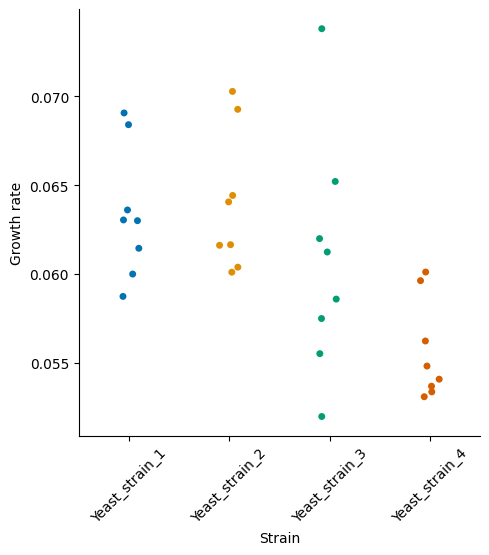

In [56]:
sns.catplot(data=growth_rates_df, x='Strain', y='Growth rate', hue='Strain', palette='colorblind')
plt.xticks(rotation=45)

We can see that strains 1, 2, and 3 have similar growth rates, while strain 4 appears to grow a little slower. In this example we showed how to use the pseudobatch transformation to transform real world data.

## References
[1] Kensy, Frank, Emerson Zang, Christian Faulhammer, Rung-Kai Tan, and Jochen Büchs. “Validation of a High-Throughput Fermentation System Based on Online Monitoring of Biomass and Fluorescence in Continuously Shaken Microtiter Plates.” Microbial Cell Factories 8, no. 1 (December 2009): 31. https://doi.org/10.1186/1475-2859-8-31.
